In [1]:
!pip install torchinfo

import glob
import re
import numpy as np
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

import copy
from torch.utils.data import DataLoader, Dataset
from torchinfo import summary
from PIL import Image
from collections import Counter

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True

In [2]:
!git clone https://github.com/Bjarten/early-stopping-pytorch/
%cd ./early-stopping-pytorch/
!python pytorchtools.py install
from pytorchtools import EarlyStopping

Cloning into 'early-stopping-pytorch'...
remote: Enumerating objects: 92, done.
remote: Total 92 (delta 0), reused 0 (delta 0), pack-reused 92
Unpacking objects: 100% (92/92), done.
/kaggle/working/early-stopping-pytorch


In [3]:
%cd ../

/kaggle/working


In [4]:
def img_files(path):  
  img=[]
  tag=[]
  for file in sorted(glob.glob(path)):
    img.append(file)
    s=re.match("^.*?-",file).group()
    if s in tag:
      continue
    else:
      tag.append(s)

  
  return img,tag

In [5]:
def preprocess_data(data):
  l=[]
  data=np.reshape(np.array(data),(-1,20))
  for i in data:
    s=re.search("(?<=-).?",i[0])
    if s.group()=='N':
      l.append(0)
    else:
      l.append(1)
  
  label=np.array(l,dtype=np.float32)

  return data,label

In [6]:
class RoboDataset(Dataset):
  def __init__(self, file,labels,transform):
    self.imagefiles=file
    self.labels=labels
    self.transform=transform
  def __len__(self):
    return len(self.imagefiles)
  def __getitem__(self,idx):
    l=[]
    for i in self.imagefiles[idx]:
      img=Image.open(i)
      l.append(img)
    frame=[]
    for j in l:
      j=self.transform(j)
      frame.append(j)
    frame=torch.stack(frame)

    return frame,self.labels[idx]

In [7]:
def matrix(output,pred_output):
  tn,fp,fn,tp=confusion_matrix(np.array(output),np.array(pred_output)).ravel()
  error_rate=(fp+fn)/(tp+fp+fn+tn)
  accuracy=(tp+tn)/(tp+fp+fn+tn)
  sensitivity=tp/(tp+fn)
  specificity=tn/(tn+fp)
  precision=tp/(tp+fp)
  false_positive_rate=1-specificity

  MCC=(tp*tn-fp*fn)/((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))**0.5
  F_score=(2*precision*sensitivity)/(precision+sensitivity)

  print("True positives: ",tp,"\nFalse positives: ",fp, "\nFalse negatives: ",fn,
  "\nTrue negatives: ",tn,"\nError rate: ",error_rate,"\nAccuracy: ",accuracy,
  "\nSensitivity: ",sensitivity,"\nSpecificity: ",specificity,"\nPrecision: ",
  precision,"\nFalse positive rate: ",false_positive_rate,"\nMCC: ",MCC,"\nF-score: ",F_score)

In [8]:
class LSTM(nn.Module):
  def __init__(self,hidden_size,num_layers,num_classes):
    super(LSTM, self).__init__()
    
    self.hidden_size=hidden_size
    self.num_layers=num_layers
    self.num_classes=num_classes
    self.backbone = torch.hub.load('/kaggle/working/trainval/yolov5/yolov5/', 'custom', source='local', path='/kaggle/working/trainval/yolov5n_backbone.pt', force_reload=True, autoshape=False)
    features=256
    for param in self.backbone.parameters():
      param.requires_grad = False
    self.pool=nn.AdaptiveAvgPool2d(1)
    self.flat=nn.Flatten()
    self.lstm = nn.LSTM(input_size=features, hidden_size=hidden_size,num_layers=num_layers, batch_first=True,dropout=0.5)    
    self.fc = nn.Linear(hidden_size, num_classes)

  def forward(self,x):
    batch, seq, C,H, W = x.size()
    c_in = x.view(batch * seq, C, H, W)
    bone_out = self.backbone(c_in)
    pool_out=self.pool(bone_out)
    flat_out=torch.flatten(pool_out)
    r_out, (h_n, h_c) = self.lstm(flat_out.view(batch,seq,-1))
    out = r_out[:, -1, :]
    out=self.fc(out)
    return out

In [9]:
def train_model(modelo,earlystop,epochs):
  train_acc=[]
  train_losses=[]
  val_acc=[]
  val_losses=[]
  epoch=[]
  
  early_stopping = EarlyStopping(patience=earlystop)
                                 
  for i in range(1,epochs):
    modelo.train()
    t_loss=0
    t_correct=0
    t_total=0
  
    for j,(inputs,labels) in enumerate(dataset):
      inputs=inputs.to(device)
      labels=labels.unsqueeze(1).to(device)
      
      optimizer.zero_grad()
      outputs=modelo(inputs)
      loss=criterion(outputs,labels)
      pred=(outputs>0.0).float()

      loss.backward()
      optimizer.step()

      t_loss += loss.item()
      t_correct+=(pred==labels).sum().item()
      t_total+=labels.size(0)

    train_loss=t_loss/len(dataset)
    acc=100.*t_correct/t_total


    print("Epoch: %d Training, loss: %1.5f, correct/total: %d / %d, accuracy:%1.3f " % (i, train_loss,t_correct,t_total,acc))
    train_acc.append(acc)
    train_losses.append(train_loss)
      
    modelo.eval()
    v_loss=0
    v_correct=0
    v_total=0

    with torch.no_grad():
      for inputs,labels in testloader:
        inputs=inputs.to(device)
        labels=labels.unsqueeze(1).to(device) 
      
        outputs=modelo(inputs)

        loss=criterion(outputs,labels)
        pred=(outputs>0.0).float()

        v_correct+=(pred==labels).sum().item()
        v_loss += loss.item()
        v_total+=labels.size(0)

    val_loss=v_loss/len(testloader)
    acc=100.*v_correct/v_total


        
    print("Epoch: %d Validation, loss: %1.5f, correct/total: %d / %d, accuracy:%1.3f " % (i, val_loss,v_correct,v_total,acc))
    val_acc.append(acc)
    val_losses.append(val_loss)
    epoch.append(i)

    early_stopping(val_loss, modelo)
          
    if early_stopping.early_stop:
        print("Early stopping")
        break
        
  modelo.load_state_dict(torch.load('checkpoint.pt'))
  return modelo,train_acc,train_losses,val_acc,val_losses,epoch

In [10]:
from distutils.dir_util import copy_tree
copy_tree('/kaggle/input/', '/kaggle/working')

['/kaggle/working/testing/test/V480-N1701.png',
 '/kaggle/working/testing/test/V665-R0701.png',
 '/kaggle/working/testing/test/V605-R3051.png',
 '/kaggle/working/testing/test/V520-N2350.png',
 '/kaggle/working/testing/test/V196-N0851.png',
 '/kaggle/working/testing/test/V395-R1190.png',
 '/kaggle/working/testing/test/V215-R2520.png',
 '/kaggle/working/testing/test/V78-N0221.png',
 '/kaggle/working/testing/test/V497-R0221.png',
 '/kaggle/working/testing/test/V236-N0151.png',
 '/kaggle/working/testing/test/V300-N0276.png',
 '/kaggle/working/testing/test/V380-N0001.png',
 '/kaggle/working/testing/test/V519-R0241.png',
 '/kaggle/working/testing/test/V124-N0381.png',
 '/kaggle/working/testing/test/V17-R1132.png',
 '/kaggle/working/testing/test/V340-N0326.png',
 '/kaggle/working/testing/test/V313-R1751.png',
 '/kaggle/working/testing/test/V500-N0251.png',
 '/kaggle/working/testing/test/V184-N0401.png',
 '/kaggle/working/testing/test/V339-R0081.png',
 '/kaggle/working/testing/test/V200-N0801.

In [11]:
train_files,tags=img_files("/kaggle/working/trainval/trainval/trainval/*.png")
trainX,trainY=preprocess_data(train_files)
valid_files,tag2=img_files("/kaggle/working/testing/test/*.png")
validX,validY=preprocess_data(valid_files)

In [12]:
train_transform=transforms.Compose([
      transforms.Resize((320,320)),
      transforms.ToTensor(),  
      transforms.Normalize([0.4335, 0.4272, 0.4201], [0.2497, 0.2502, 0.2524]),
                            
])

valid_transform=transforms.Compose([
      transforms.Resize((320,320)),
      transforms.ToTensor(),  
      transforms.Normalize([0.4335, 0.4272, 0.4201], [0.2497, 0.2502, 0.2524]),
                           
])

In [13]:
prueba=RoboDataset(trainX,trainY,transform=train_transform)
dataset=DataLoader(prueba,batch_size=32,shuffle=True)
valid=RoboDataset(validX,validY,transform=valid_transform)
testloader=DataLoader(valid,batch_size=32, num_workers=0)

In [14]:
epochs=50
hidden_size=51
num_layers=3
num_classes=1
learning_rate=0.0012825
earlystop=7

modelo = LSTM(hidden_size, num_layers,num_classes)
modelo.to(device)
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(modelo.parameters(), lr=learning_rate)
modelo,train_acc,train_losses,val_acc,val_losses,epoch=train_model(modelo,earlystop,epochs)

Epoch: 1 Training, loss: 0.68758, correct/total: 437 / 791, accuracy:55.247 
Epoch: 1 Validation, loss: 0.66865, correct/total: 80 / 136, accuracy:58.824 
Epoch: 2 Training, loss: 0.66491, correct/total: 483 / 791, accuracy:61.062 
Epoch: 2 Validation, loss: 0.63762, correct/total: 80 / 136, accuracy:58.824 
Epoch: 3 Training, loss: 0.62063, correct/total: 527 / 791, accuracy:66.625 
Epoch: 3 Validation, loss: 0.57881, correct/total: 92 / 136, accuracy:67.647 
Epoch: 4 Training, loss: 0.60760, correct/total: 538 / 791, accuracy:68.015 
Epoch: 4 Validation, loss: 0.59837, correct/total: 87 / 136, accuracy:63.971 
EarlyStopping counter: 1 out of 7
Epoch: 5 Training, loss: 0.56353, correct/total: 575 / 791, accuracy:72.693 
Epoch: 5 Validation, loss: 0.55926, correct/total: 98 / 136, accuracy:72.059 
Epoch: 6 Training, loss: 0.55891, correct/total: 560 / 791, accuracy:70.796 
Epoch: 6 Validation, loss: 0.54925, correct/total: 97 / 136, accuracy:71.324 
Epoch: 7 Training, loss: 0.54610, co

In [15]:
path='modelo.pth'
torch.save(modelo.state_dict(), path)

In [16]:
summary(modelo,(8,20,3,320,320))

Layer (type:depth-idx)                             Output Shape              Param #
LSTM                                               [8, 1]                    --
├─Model: 1-1                                       [160, 256, 10, 10]        --
│    └─Sequential: 2-1                             --                        7,328
│    │    └─Conv: 3-1                              [160, 16, 160, 160]       (1,744)
│    │    └─Conv: 3-2                              [160, 32, 80, 80]         (4,640)
│    │    └─C3: 3-3                                [160, 32, 80, 80]         (4,704)
│    │    └─C3: 3-6                                [160, 64, 40, 40]         (recursive)
│    │    └─Conv: 3-5                              [160, 64, 40, 40]         (18,496)
│    │    └─C3: 3-6                                [160, 64, 40, 40]         (recursive)
│    │    └─C3: 3-9                                [160, 128, 20, 20]        (recursive)
│    │    └─Conv: 3-8                              [160, 128, 20

In [17]:
%matplotlib inline

Text(0.5, 1.0, 'Train vs Valid Losses')

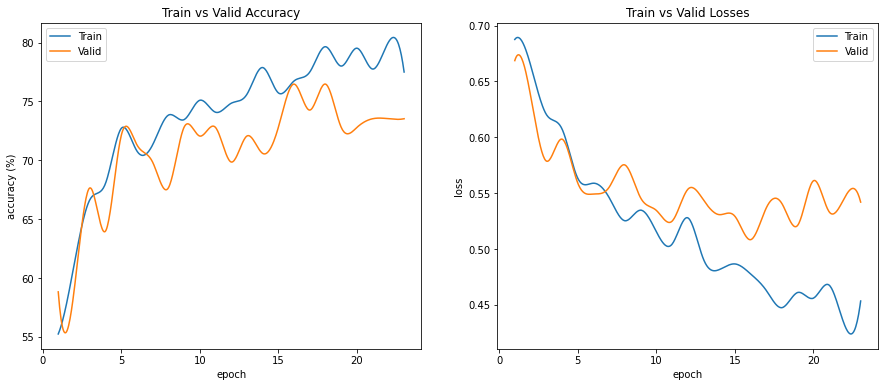

In [18]:
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
xa=np.linspace(1,epoch[-1],500)
ya1=make_interp_spline(epoch,train_acc)(xa)
ya2=make_interp_spline(epoch,val_acc)(xa)
yl1=make_interp_spline(epoch,train_losses)(xa)
yl2=make_interp_spline(epoch,val_losses)(xa)

fig, axs = plt.subplots(1,2,figsize=(15,6))

axs[0].plot(xa,ya1)
axs[0].plot(xa,ya2)
axs[0].set(xlabel='epoch',ylabel='accuracy (%)')
axs[0].legend(['Train','Valid'])
axs[0].set_title('Train vs Valid Accuracy')
 
axs[1].plot(xa,yl1)
axs[1].plot(xa,yl2)
axs[1].set(xlabel='epoch',ylabel='loss')
axs[1].legend(['Train','Valid'])
axs[1].set_title('Train vs Valid Losses')

In [19]:
from sklearn.metrics import confusion_matrix

output=[]
pred_output=[]

for inputs,labels in testloader:
     
     outputs=modelo(inputs.to(device))
     pred=(outputs>0.0).float()

     pred_output.extend(pred.cpu().flatten().numpy())

     labels=labels.data.numpy()
     output.extend(labels)

In [20]:
matrix(output,pred_output)

True positives:  37 
False positives:  13 
False negatives:  19 
True negatives:  67 
Error rate:  0.23529411764705882 
Accuracy:  0.7647058823529411 
Sensitivity:  0.6607142857142857 
Specificity:  0.8375 
Precision:  0.74 
False positive rate:  0.16249999999999998 
MCC:  0.5085351250621012 
F-score:  0.6981132075471698
